### Vishnu Bharadwaj M N (211EE163)
### Assignment 2 ROBDD 

Enter the number of variables: 7
Enter name of variable 1: a
Enter name of variable 2: b
Enter name of variable 3: c
Enter name of variable 4: d
Enter name of variable 5: e
Enter name of variable 6: f
Enter name of variable 7: g
Enter Boolean expression using variables ['a', 'b', 'c', 'd', 'e', 'f', 'g'] (e.g., a & b | ~c): (a & b & ~c) | (d & e & ~f) | (~g)
Enter variable ordering (e.g., a b c d e f g): abcdefg
Displaying ROBDD:
Node2: Variable = g, Low = Node1, High = Node0
Node3: Variable = f, Low = Node1, High = Node2
Node4: Variable = e, Low = Node2, High = Node3
Node5: Variable = d, Low = Node2, High = Node4
Node6: Variable = c, Low = Node1, High = Node5
Node7: Variable = b, Low = Node5, High = Node6
Node8: Variable = a, Low = Node5, High = Node7


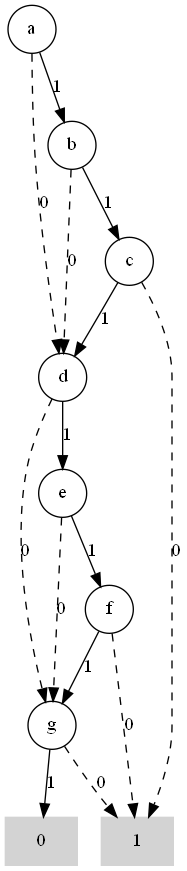

In [12]:
from sympy.logic.boolalg import Or, And, Not
from sympy import symbols, sympify
from itertools import product
from graphviz import Digraph
from IPython.display import Image, display

class BDDNode:
    def __init__(self, var, low, high, id=None):
        self.var = var
        self.low = low
        self.high = high
        self.id = id

    def __repr__(self):
        return f"BDDNode({self.var}, {self.low}, {self.high})"

class ROBDD:
    def __init__(self, sop_expr, variable_order):
        self.sop_expr = sop_expr
        self.var_ord = variable_order
        self.node_count = 2
        self.unique_table = {}
        self.terminal_nodes = {}
        self.create_terminal_nodes()
        self.bdd = self.build_bdd()

    def create_terminal_nodes(self):
        self.terminal_nodes[0] = BDDNode(None, None, None, 0)  # Terminal 0
        self.terminal_nodes[1] = BDDNode(None, None, None, 1)  # Terminal 1

    def build_bdd(self):
        minterms = self.parse_expression_to_minterms()
        return self.build_from_minterms(minterms, self.var_ord)

    def parse_expression_to_minterms(self):
        expr = self.sop_expr
        variables = list(set(self.var_ord))
        symbols_dict = {var: symbols(var) for var in variables}

        minterms = set()
        for values in product([0, 1], repeat=len(variables)):
            assignment = {var: val for var, val in zip(variables, values)}
            expr_value = self.evaluate_expression(expr, symbols_dict, assignment)
            if expr_value:
                minterm = ''.join(str(assignment[var]) for var in self.var_ord)
                minterms.add(minterm)
        return minterms

    def evaluate_expression(self, expr, symbols_dict, assignment):
        eval_expr = expr.subs({symbols_dict[var]: bool(val) for var, val in assignment.items()})
        return bool(eval_expr)

    def build_from_minterms(self, minterms, variable_order, index=0):
        if len(minterms) == 0:
            return self.terminal_nodes[0]
        if len(minterms) == 2 ** (len(self.var_ord) - index):
            return self.terminal_nodes[1]

        if index == len(self.var_ord):
            return self.terminal_nodes[1 if "1" in minterms else 0]

        var = self.var_ord[index]
        low_set = {m for m in minterms if m[index] == '0'}
        high_set = {m for m in minterms if m[index] == '1'}

        low_node = self.build_from_minterms(low_set, self.var_ord, index + 1)
        high_node = self.build_from_minterms(high_set, self.var_ord, index + 1)

        return self.make_node(var, low_node, high_node)

    def make_node(self, var, low, high):
        if low == high:
            return low

        node_id = (var, low.id, high.id)
        if node_id in self.unique_table:
            return self.unique_table[node_id]

        new_node = BDDNode(var, low, high, self.node_count)
        self.node_count += 1
        self.unique_table[node_id] = new_node
        return new_node

    def display(self):
        print("Displaying ROBDD:")
        for node in self.unique_table.values():
            print(f"Node{node.id}: Variable = {node.var}, Low = Node{node.low.id}, High = Node{node.high.id}")
        self.generate_graph()

    def generate_graph(self):
        dot = Digraph()

        dot.node("0", "0", shape="box", style="filled", color="lightgrey")
        dot.node("1", "1", shape="box", style="filled", color="lightgrey")
        for node in self.unique_table.values():
            dot.node(str(node.id), str(node.var), shape="circle")
            dot.edge(str(node.id), str(node.low.id), label="0", style="dashed")
            dot.edge(str(node.id), str(node.high.id), label="1")

        dot.format = 'png'
        dot.render('robdd_output')
        display(Image('robdd_output.png'))

if __name__ == "__main__":
    # Input the number of variables
    num_vars = int(input("Enter the number of variables: "))
    variables = []

    # Input the variable names
    for i in range(num_vars):
        var = input(f"Enter name of variable {i + 1}: ").strip()
        if not var:  # Check if the variable name is empty
            print("Variable name cannot be empty. Please enter a valid variable name.")
            exit()
        variables.append(var.lower())

    # Input the SoP Boolean expression
    b_ex = input(f"Enter Boolean expression using variables {variables} (e.g., a & b | ~c): ")

    # Input the variable ordering
    var_ord = input(f"Enter variable ordering (e.g., {' '.join(variables)}): ").strip().lower()

    # Convert the input expression to sympy format
    sop_expr = sympify(b_ex)

    # Create the ROBDD
    robdd = ROBDD(sop_expr, var_ord)
    robdd.display()
